# ДЗ №5

Задание из 2-х частей.
Берем отызывы за лето (из архива с материалами или предыдущего занятия)

### Загрузка данных

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
# nltk.download("punkt")

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [72]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

def getVocabulary(corpus):
    tokens = word_tokenize(corpus.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]

    dist = FreqDist(tokens_filtered)
    tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

    return {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [85]:
data = pd.read_csv("отзывы за лето.csv", sep=';')
data['Content'] = data['Content'].apply(preprocess_text)
data['Rating'] = data['Rating']-1

In [139]:
max_len = 100
max_words = 2000
num_classes = data['Rating'].nunique()

In [140]:
train, test = train_test_split(data,  random_state=42, test_size=0.2)
train, val  = train_test_split(train, random_state=42, test_size=0.2)

vocabulary = getVocabulary(" ".join(train["Content"]))

def getX(df):
    return np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df["Content"]], dtype=np.int32)

x_train = getX(train)
x_test = getX(test)
x_val = getX(val)

In [141]:
x_train.shape, x_test.shape, x_val.shape

((13221, 100), (4132, 100), (3306, 100))

### 1. Учим conv сеть для классификации - выбить auc выше 0.95

In [142]:
y_train = keras.utils.to_categorical(train["Rating"], num_classes)
y_val = keras.utils.to_categorical(val["Rating"], num_classes)
y_test = keras.utils.to_categorical(test["Rating"], num_classes)

In [174]:
nn = 128

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=nn, input_length=max_len))

model.add(Conv1D(nn, 10))
model.add(Activation("relu"))

model.add(Conv1D(nn, 5))
model.add(Activation("relu"))

model.add(Conv1D(nn, 3))
model.add(Activation("relu"))

model.add(Conv1D(nn, 3))
model.add(Activation("relu"))
model.add(MaxPooling1D(3))

model.add(Conv1D(nn, 3))
model.add(Activation("relu"))
model.add(MaxPooling1D(3))

model.add(GlobalMaxPool1D())

model.add(Dense(nn))
model.add(Activation("relu"))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 256)          512000    
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 91, 256)           655616    
_________________________________________________________________
activation_91 (Activation)   (None, 91, 256)           0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 87, 256)           327936    
_________________________________________________________________
activation_92 (Activation)   (None, 87, 256)           0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 85, 256)           196864    
_________________________________________________________________
activation_93 (Activation)   (None, 85, 256)         

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 30
batch_size = 512

early_stopping=EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

/Users/xander/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13221 samples, validate on 3306 samples
Epoch 1/30
13221/13221 [==============================] - 211s 16ms/step - loss: 1.1054 - accuracy: 0.6826 - val_loss: 0.9023 - val_accuracy: 0.7275
Epoch 2/30
 4096/13221 [========>.....................] - ETA: 2:39 - loss: 0.9617 - accuracy: 0.7273

In [146]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

4132/4132 [==============================] - 2s 375us/step
Test score: 0.738131383381647
Test accuracy: 0.765972912311554


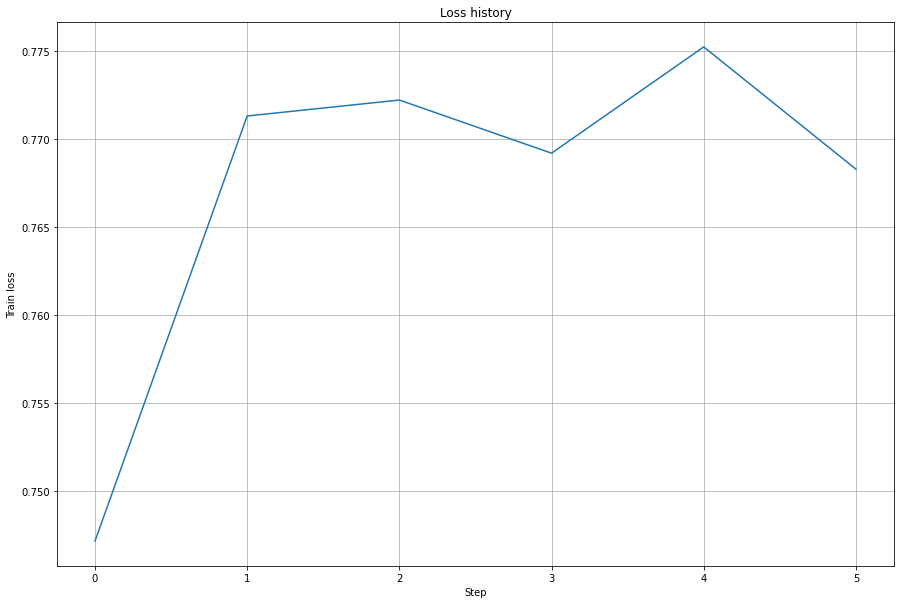

In [151]:
plt.figure(figsize=(15,10))
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(history.history['val_accuracy']);
plt.show()

### 2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

In [ ]:
# Work IN Progress